In [45]:
# ! pip install --upgrade pip
# ! pip install --user numpy scipy matplotlib pyhf iminuit json corner mplhep

In [46]:
import pyhf
from scipy import stats
import numpy as np
import json
import mplhep as hep
import matplotlib.pyplot as plt


# Hypothesis tests with pyhf

This notebook will provide you with the tools to do sensitivity estimates which can be used for search region optimization or sensitivity projections.

## p-value for discovery of a new signal

In searches for new physics we want to know how significant a potential deviation from our Standard Model (SM) expectation is. We do this by a hypothesis test where we try to exclude the SM ("background only") hypothesis. We use a so called **p-value** $p_0$ for this, abstractly defined by:

$$p_0 = \int\limits_{t_\mathrm{obs}}^{\infty}p(t|H_0)\mathrm{d}t$$

where $t$ is a test statistic (a number we calculate from our data observations) and $p(t|H_0)$ is the probability distribution for $t$ under the assumption of our **null Hypothesis** $H_0$, in this case the background only hypothesis. This p-value is then typically converted into a number of standard deviations $z$, the **significance** ("number of sigmas") via the inverse of the cumulative standard normal distribution $\Phi$:

$$z = \Phi^{-1}(1 - p)$$

The typical convention for particle physics is to speak of *evidence* when $z>3$ and of an *observation* when $z>5$.

So what do we use for $t$? We want to use something that discriminates well between our null Hypothesis and an **alternative Hypothesis** that we have in mind. When we try to discover new physics, our null Hypothesis is the absence and the alternative Hypothesis the presence of a signal. We can parametrize this by a **signal strength** parameter $\mu$. The test statistics used in almost all LHC searches use the **profile likelihood ratio**

$$\Lambda_\mu = \frac{L(\mu, \hat{\hat{\theta}})}{L(\hat{\mu}, \hat{\theta})}$$

where $\theta$ are the other parameters of our model that are not part of the test, the so called **nuisance parameters**. In contrast, the parameter that we want to test, $\mu$, is called our **parameter of interest** (POI). The nuisance parameters include all fit parameters, like normalization factors and parameters for describing uncertainties. $L(\mu, \hat{\hat{\theta}})$ is the Likelihood function, maximized under the condition that our parameter of interest takes the value $\mu$ and $L(\hat{\mu}, \hat{\theta})$ is the unconditionally maximized Likelihood. So roughly speaking, we are calculating the fraction of the maximum possible likelihood that we can get under our test condition. If it is high, that speaks for our hypothesis, if it is low, against. The test statistic $t_\mu$ is then defined as

$$t_\mu = -2\ln\Lambda_\mu$$

giving us a test statistic where **high values speak against the null hypothesis**.

<div class="alert alert-block alert-success">
    <b>Question 1:</b> If we want to discover a new signal (using the p-value $p_0$), which value of $\mu$ are we testing against? Or in other words, what is our null Hypothesis?
</div>

All that's left now is to know the distribution of $p(t_\mu|H_0)$. [Wilk's theorem](https://en.wikipedia.org/wiki/Wilks%27_theorem) tells us that the distribution of $t_\mu$ is asymptotically (for large sample sizes) a chi-square distribution. For the discovery p-value we use a slightly modified version of test statistic, called $q_0$ where $\hat{\mu}$ is required to be $>=0$ ($q_0=0$ for $\hat{\mu} < 0$). For $q_0$ the p-value in the asymptotic limit collapses to a very simple formula:

$$p_0 = \sqrt{q_0}$$

The asymptotic limit often matches quite well even for fairly small sample sizes, but it should be kept in mind this is an approximation. Alternatively, one can evaluate $p(t_\mu|H_0)$ by Monte Carlo sampling ("toys").

## CLs for exclusion of an absent signal

Now, sadly, not all searches find evidence for new physics. What we still can do in such a case is to try exclude models by rejecting the hypothesis of a signal being present. That usually means we test against $\mu=1$ or some other value $>0$. The rest of the procedure is very similar with one small detail worth mentioning ... In high energy physics it is very common to use a quantity called $CL_s$ instead of plain p-value. It is defined by

$$CL_s = \frac{CL_{s+b}}{CL_{b}}$$

where $CL_{s+b}$ is the p-value for rejecting the hypothesis of signal + background being present (what would be the "normal" p-value) and $CL_{b}$ is the p-value for rejecting the background only hypothesis, but now using the test statistic for $\mu=1$ (so this is different from $p_0$!). We won't go into further details how to calculate those p-values. `pyhf` has the formulas included and does it automatically for us. The asymptotic distributions for all different variants are described in the paper "Asymptotic formulae for likelihood-based tests of new physics" ([arXiv:1007.1727](https://arxiv.org/abs/1007.1727)).

Just a qualitative explanation of why we use $CL_s$ instead of the p-value: We want to avoid excluding signals in cases where we don't have sensitivity, but observe an *underfluctuation* of the data. In these cases $CL_{s+b}$ and $CL_b$ will be very similar and consequently lead to a large value of $CL_{s}$, telling us the signal is **not** excluded. In case our observations are exactly on spot with the background expectations $CL_b = 0.5$ in the asymptotic limit, so on average we have twice as high "p-values" with $CL_s$.

The typical convention for particle physics is to speak of an **exclusion** of a signal if $CL_s < 0.05$. That's usually what is meant by "limit at 95% confidence level".

## Discovery or exclusion of a signal for a cut & count experiment

Let's start with a simple case where we only want to count the number of events in a certain search region. We assume a certain number of expected background events `b`, expected signal events `s` and a total uncertainty on the expected background `delta_b` ($\sigma_b$).

The likelihood function for this can be formulated as a primary measurement of `n` events and a control ("auxiliary") measurment of `m` events that constrains our background parameter within the uncertainty. So, a product of 2 Poisson distributions:

$$L(s, b) = \mathrm{Pois}(n|s + b)\cdot \mathrm{Pois}(m|\tau b)$$

The parameter $\tau$ can be given in terms of $\sigma_b$ by asking the question "How much more events do i have to measure in the control region to get the relative uncertainty $\sigma_b / b$". That gives

$\tau = \frac{b}{\sigma_b^2}$

Equivalently, we can replace $b$ by $\gamma b$ and $s$ by $\mu s$ to fit normalization factors (initialized to 1) and keep $s$ and $b$ fixed to our expectation.

$$L'(\mu, \gamma) = L(\mu s, \gamma b)$$

`pyhf` has a convenience function to create the specification for such a model: `pyhf.simplemodels.uncorrelated_background`. It also works for arbitrary many bins, but for now let's go with one bin and 5 expected background events, 7 expected signal events and an uncertainty of 2 on the expected background events:

In [8]:
s = 7
b = 5
delta_b = 2

In [9]:
model = pyhf.simplemodels.uncorrelated_background(
    signal=[s], bkg=[b], bkg_uncertainty=[delta_b]
)

The model comes with a "parameter of interest" (POI) called `mu` that is our signal strength:

In [10]:
model.config.poi_name

'mu'

In addition, we have one nuisance parameter, the constrained background normalization $\gamma$, called `uncorr_bkguncrt` here:

In [11]:
model.config.par_order

['mu', 'uncorr_bkguncrt']

It's initial value should be 1

In [12]:
gamma_initial = 1

So the expected data in our model scales with `mu`. For `mu=1` we get `5 * 1 * 7 = 12`

In [13]:
model.expected_actualdata([1, gamma_initial])

array([12.])

for `mu=2` we get `5 + 2 * 7 = 19`

In [14]:
model.expected_actualdata([2, gamma_initial])

array([19.])

The auxiliary data corresponds to $\tau b$ in the formula above:

In [15]:
model.config.auxdata

[6.25]

It's given by our background uncertainty `delta_b`:

In [16]:
b ** 2 / (delta_b ** 2)

6.25

To get the p-value for rejection of the background only hypothesis, we call `pyhf.infer.hypotest` with the test value 0 of our POI $\mu$ using the `q0` test statistic.

We want to know which p-value we would get if we would observe an excess of events of precisely the expected signal, so we plug in `s + b` for the data:

In [17]:
pvalue = pyhf.infer.hypotest(
    poi_test=0,
    data=[s + b] + model.config.auxdata,
    pdf=model,
    test_stat="q0"
)
pvalue

array(0.03354823)

We can convert this into a significance (number of standard deviations) using the inverse of the cumulative standard normal distribution $\Phi$

$$z = \Phi^{-1}(1 - p)$$

The function [`scipy.stats.norm.isf`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.norm) ("inverse survival function") calculates $\Phi^{-1}(1 - p)$ in a numerically stable way (also for small p-values).

In [18]:
def pvalue_to_significance(pvalue):
    return stats.norm.isf(pvalue)

In [19]:
pvalue_to_significance(pvalue)

1.831027300134541

That would not count as "Evidence" yet.

<div class="alert alert-block alert-success">
    <b>Question 2:</b> How much excess events would we need to observe in our search region (assuming unchanged expected background) that we have potential for finding evidence (3 $\sigma$) of a new signal?  Can you plot significance as a function of inceasing number of events?
</div>

<Figure size 360x360 with 0 Axes>

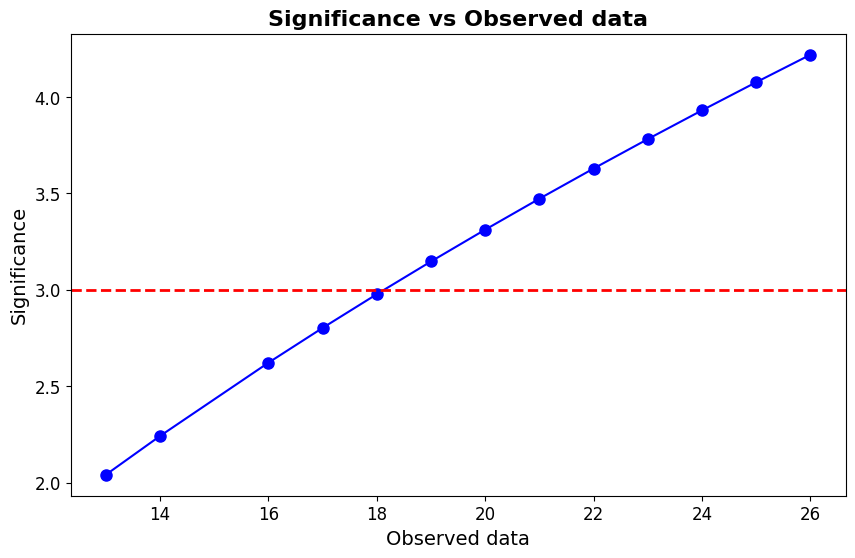

In [20]:
added_values = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

significances=[]
datas=[]

for data_point in added_values :
    pvalue = pyhf.infer.hypotest(
             poi_test=0,
             data=[s + b + data_point] + model.config.auxdata,
             pdf=model,
             test_stat="q0")
    #print([s + b + data_point] + model.config.auxdata)
    datas.append(s + b + data_point)
    significance=pvalue_to_significance(pvalue)
    significances.append(significance)


# Plot the significance as a function of increasing data
plt.figure(figsize=(5, 5))
plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(datas, significances, marker='o', linestyle='-', color='b', markersize=8, label='Significance')
ax.set_xlabel('Observed data', fontsize=14)
ax.set_ylabel('Significance', fontsize=14)
ax.set_title('Significance vs Observed data', fontsize=16, weight='bold')
ax.axhline(y=3, color='red', linestyle='--', linewidth=2, label='Threshold (y=3)')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(False)
plt.show()

Equivalently we can test for exclusion and calculate $CL_s$. For that we use 1 as the test value for $\mu$ and the `qtilde` test statistic.

We want to know if we could exclude a signal if we would not observe any more data than our background expectation, so we set our data to `b`:

In [21]:
CLs = pyhf.infer.hypotest(
    poi_test=1,
    data=[b] + model.config.auxdata,
    pdf=model,
    test_stat="qtilde"
)
CLs

array(0.03836407)

Would you exclude signal if you had 1 more background event?

In [22]:
CLs = pyhf.infer.hypotest(
    poi_test=1,
    data=[b+1] + model.config.auxdata,
    pdf=model,
    test_stat="qtilde"
)
CLs

array(0.06923316)

Now we talked about $CL_{s}$ being the ratio between $CL_{s+b}$ and $CL_{b}$, in `pyhf` you can access this information by setting the following argument `return_tail_probs=True`.

In [23]:
CLs_obs, CLsb_CLb = pyhf.infer.hypotest(
    poi_test=1,
    data=[b] + model.config.auxdata,
    pdf=model,
    return_tail_probs=True,
    test_stat="qtilde"
)

print('Value for CLsb: ' + str(CLsb_CLb[0]))
print('Value for CLb: ' + str(CLsb_CLb[1]))
print('Value for CLs=CLsb/CLb: '+ str(CLs_obs))

Value for CLsb: 0.019182034571438175
Value for CLb: 0.5
Value for CLs=CLsb/CLb: 0.03836406914287635


To calculate expected values in `pyhf.infer.hypotest` set `return_expected_set=True` to true.

In [24]:
CLs_obs, CLs_exp_band = pyhf.infer.hypotest(
    poi_test=1,
    data=[b] + model.config.auxdata,
    pdf=model,
    return_expected_set=True,
    test_stat="qtilde"
)
print(CLs_obs)
print(CLs_exp_band)

0.03836406914287635
[array(0.00102907), array(0.00672475), array(0.03836407), array(0.16889319), array(0.48270288)]




<div class="alert alert-block alert-success">
    <b>Question 2:</b> Do you recognize what this corresponds to in the famous CLs plot?
</div>

Now this is only one point and usually one produces something called a brazil band = $CL_{s}$ plot, so let's do that with `pyhf` using `pyhf.infer.hypotest`. For this we have to scan! - let's see what the lowest possible value (and the 1 and 2 $\sigma$ bands) for $\mu$ that is excluded with $CL_s<0.05$. Let's scan with 31 points between 0 and 3:

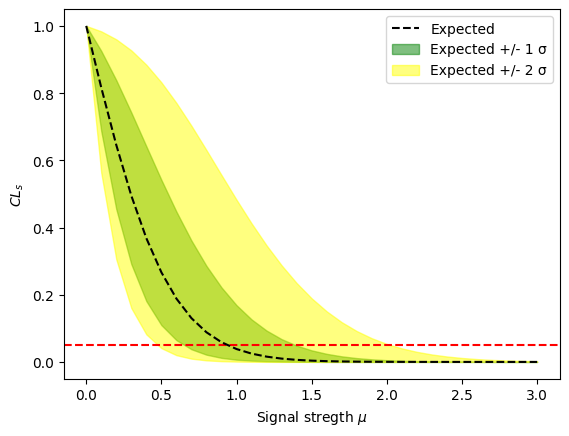

In [25]:
mu_scan = np.linspace(0, 3, 31)
results = [
    pyhf.infer.hypotest(mu, [b] + model.config.auxdata, model, return_expected_set=True, test_stat="qtilde")
    for mu in mu_scan
]
# for this example we only need the expected band (second return value)
# let's also convert this to a numpy array, such that we can slice it column-wise
results = np.array([r[1] for r in results])



def plot_scan(scan_parameters, results, exclusion_level=0.05, ax=None):
    ax = ax or plt.gca()
    ax.axhline(exclusion_level, linestyle="--", color="red")
    ax.plot(scan_parameters, results[:, 2], "--", color="black", label="Expected")
    ax.fill_between(
        scan_parameters, results[:, 1], results[:, 3], alpha=0.5, color="green", label="Expected +/- 1 σ"
    )
    ax.fill_between(
        scan_parameters, results[:, 0], results[:, 4], alpha=0.5, color="yellow", label="Expected +/- 2 σ"
    )
    return ax


ax = plot_scan(mu_scan, results)
ax.set_xlabel("Signal stregth $\mu$")
ax.set_ylabel("$CL_s$")
ax.legend()

By looking where the red line crosses the expected line and the error bands we can conclude that the minimum signal strength we expect to exclude in case of no excess events is slightly below 1. We would expect that limit to fluctuate between $\approx$ 0.6 and 1.4 at $1\sigma$ level and 0.5 to 2 at $2\sigma$ level.

`pyhf` also has a convenience function to run the scan and interpolate this for us, so we don't need to read it from the plot with a ruler ;)


In [26]:
pyhf.infer.intervals.upper_limits.upper_limit([b] + model.config.auxdata, model)

(array(0.93802498),
 [array(0.47172138),
  array(0.64849741),
  array(0.93802498),
  array(1.3915076),
  array(2.02441462)])

So let us assume that that we see 20 observed events, let's plot the observed $CL_{s}$ value as well.

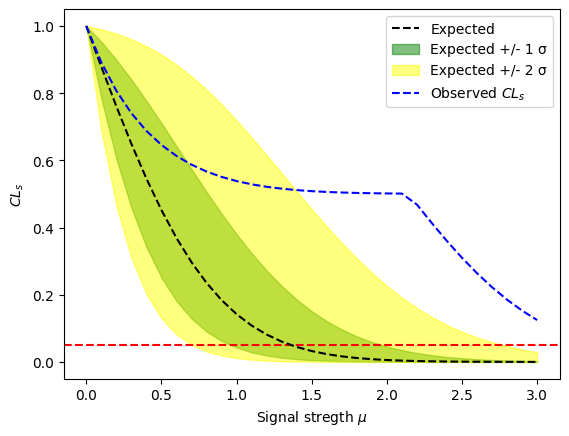

In [27]:
observations = [20]
data = pyhf.tensorlib.astensor(observations + model.config.auxdata)


results = [
    pyhf.infer.hypotest(mu, data, model, return_expected_set=True, test_stat="qtilde")
    for mu in mu_scan
]
# for this example we only need the expected band (second return value)
# let's also convert this to a numpy array, such that we can slice it column-wise

observed_CLs=np.array([r[0] for r in results])
expected_CLs = np.array([r[1] for r in results])
ax = plot_scan(mu_scan, expected_CLs)
ax.plot(mu_scan, observed_CLs, label='Observed $CL_s$', color='blue', linestyle="--")
ax.set_xlabel("Signal stregth $\mu$")
ax.set_ylabel("$CL_s$")
ax.legend()

<div class="alert alert-block alert-success">
    <b>Question 3:</b> Can you plot it with three events?
</div>

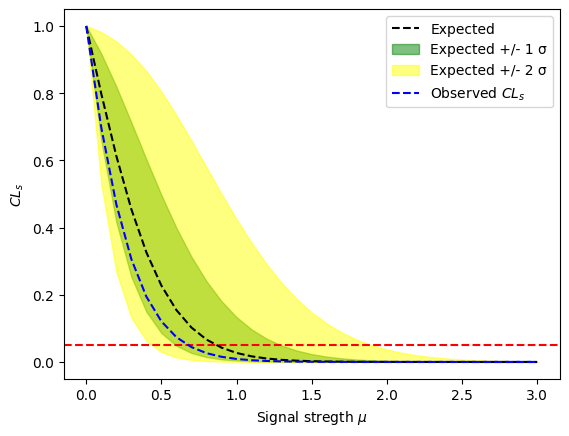

In [28]:
observations = [3]
data = pyhf.tensorlib.astensor(observations + model.config.auxdata)


results = [
    pyhf.infer.hypotest(mu, data, model, return_expected_set=True, test_stat="qtilde")
    for mu in mu_scan
]
# for this example we only need the expected band (second return value)
# let's also convert this to a numpy array, such that we can slice it column-wise

observed_CLs=np.array([r[0] for r in results])
expected_CLs = np.array([r[1] for r in results])
ax = plot_scan(mu_scan, expected_CLs)
ax.plot(mu_scan, observed_CLs, label='Observed $CL_s$', color='blue', linestyle="--")
ax.set_xlabel("Signal stregth $\mu$")
ax.set_ylabel("$CL_s$")
ax.legend()

<div class="alert alert-block alert-success">
    <b>Question 4:</b> What can you tell about behaviour for little signal or lot of signal?
</div>

<div class="alert alert-block alert-success">
    <b>Bonus question 1:</b> According to this method, what would be the upper limit on the number of excess events in case of exactly 0 expected background events (no uncertainty)? Follow up question: Is that correct? Or in other words: How well does the asymptotic limit do here? <b>Hint:</b> To create a model with negligible background you have to set the background expectation to a small value (e.g. <code>1e-10</code>) since the $\lambda$ parameter of a poisson distribution has to be strictly greater than 0.
</div>

# Low statistics

We have used a asymptotic calculator that uses Wilk's theorem to calculate a limit, which is only valid in case of high statistics. In case you have to deal with low statistics scenario it is always good to use `toy-based calculator`. In order to do so, you can set `calctype="toybased"`. These distributions are produced by generating pseudo-data (“toys”) with the nuisance parameters set to their conditional maximum likelihood estimators at the corresponding value of the parameter of interest for each hypothesis.


In [29]:
CLs_obs, CLsb_CLb = pyhf.infer.hypotest(
    poi_test=1,
    data=[b+1] + model.config.auxdata,
    pdf=model,
    return_tail_probs=True,
    test_stat="qtilde",
    calctype="toybased"
    
)

print('Value for CLsb: ' + str(CLsb_CLb[0]))
print('Value for CLb: ' + str(CLsb_CLb[1]))
print('Value for CLs=CLsb/CLb: '+ str(CLs_obs))

Value for CLsb: 0.046
Value for CLb: 0.619
Value for CLs=CLsb/CLb: 0.07431340872374798


<div class="alert alert-block alert-success">
    <b>Question 5:</b> 
    Have you observed any differences with respect to asymptotic calculator?
</div>


1. Value changes everytime you run this
2. It takes time, because the default number of toys is around 2000!
How can you make this process faster?
In fact you can change the number of toys in the generator using the following function `pyhf.infer.calculators.ToyCalculator` to do so. This comes at the cost of accuracy.

In [30]:
mu_test=1.0
data = [b] + model.config.auxdata
toy_calculator = pyhf.infer.calculators.ToyCalculator(data, model, ntoys=100)
q_tilde = toy_calculator.teststatistic(mu_test)
sig_plus_bkg_dist, bkg_dist = toy_calculator.distributions(mu_test)
sig_plus_bkg_dist.pvalue(mu_test), bkg_dist.pvalue(mu_test)
CLsb, CLb, CLs = toy_calculator.pvalues(q_tilde, sig_plus_bkg_dist, bkg_dist)
print('Value for CLsb: ' + str(CLsb))
print('Value for CLb: ' + str(CLb))
print('Value for CLs=CLsb/CLb: '+ str(CLs))

Value for CLsb: 0.03
Value for CLb: 0.53
Value for CLs=CLsb/CLb: 0.056603773584905655


The full scan will take long!

In [ ]:
#this will take long

mu_scan = np.linspace(0, 3, 5)
results = [pyhf.infer.hypotest(
    mu, [b] + model.config.auxdata, model, return_expected_set=True, test_stat="qtilde", calctype='toybased'
    )
    for mu in mu_scan]
# for this example we only need the expected band (second return value)
# let's also convert this to a numpy array, such that we can slice it column-wise
results = np.array([r[1] for r in results])

ax = plot_scan(mu_scan, results)
ax.set_xlabel("Signal stregth $\mu$")
ax.set_ylabel("$CL_s$")
ax.legend()

## Run an upper limit scan on signal parameters

Now, often we are not only interested in one particular signal, like in this workshop to be more precise, but we might have a certain class of signal models in mind and ask ourselves which parameters of that model are excluded.

What we can do is run an upper limit scan for each parameter and look for which parameters the excluded signal strength is below 1!

To get something that looks realistic simplified version of a fit to 9 bins using the [published data from the ATLAS SUSY 1L Wh analysis](https://doi.org/10.17182/hepdata.90607.v3) was prepared. If you are interested how the procedure of simplifiying the model work, have a look at [dump_signal_grid.ipynb](dump_signal_grid.ipynb).

Lets load it! We have the following background expectations for each bin:

In [31]:
with open("example_background.json") as f:
    b_9bins = json.load(f)

In [32]:
b_9bins

[13.00659260848957,
 9.84251410934949,
 6.668866664075592,
 3.84335063984653,
 5.928258939016435,
 1.837121080628339,
 6.4399309680624,
 4.616131198108342,
 1.6039841463924573]

And we have a long list of signal models for a SUSY process with a chargino/neutralino pair ($\tilde{\chi}_1^{\pm}/\tilde{\chi}_2^{0}$) that each decay into the lightest neutralino $\tilde{\chi}_1^{0}$, while emitting a W Boson and a Higgs Boson.

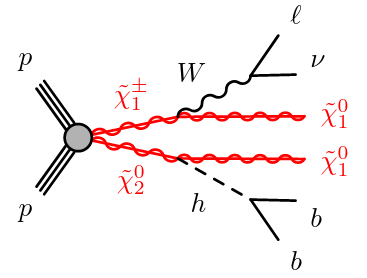

The model parameters are the $\tilde{\chi}_1^{\pm}/\tilde{\chi}_2^{0}$ mass (assumed to be the same) and the $\tilde{\chi}_1^{0}$ mass. We call them `x` and `y` in the following.

In [33]:
with open("example_signals.json") as f:
    signals_9bins = json.load(f)

In [34]:
signals_9bins

[{'x': 1000,
  'y': 0,
  'data': [0.010885407216846943,
   0.04867178201675415,
   0.1386701762676239,
   0.030669409781694412,
   0.08809207379817963,
   0.25697430968284607,
   0.299879789352417,
   0.3753739297389984,
   1.792580485343933]},
 {'x': 1000,
  'y': 100,
  'data': [0.018754690885543823,
   0.04145063832402229,
   0.17453598976135254,
   0.018347250297665596,
   0.050798844546079636,
   0.2963657081127167,
   0.24594083428382874,
   0.5206209421157837,
   1.8391799926757812]},
 {'x': 1000,
  'y': 150,
  'data': [0.023146294057369232,
   0.039490118622779846,
   0.210637167096138,
   0.042197853326797485,
   0.05113246291875839,
   0.2510533034801483,
   0.39916881918907166,
   0.43409013748168945,
   1.6555986404418945]},
 {'x': 1000,
  'y': 200,
  'data': [0.026360932737588882,
   0.06841520965099335,
   0.19323571026325226,
   0.03505992516875267,
   0.05682523176074028,
   0.18298614025115967,
   0.3036608099937439,
   0.34920915961265564,
   1.591480016708374]},
 {'x'

<div class="alert alert-block alert-success">
    <b>Question 6:</b> 
    Can you visualize few of the models?
</div>


Let's plot a few random signal models against the background expectation for all 9 bins:

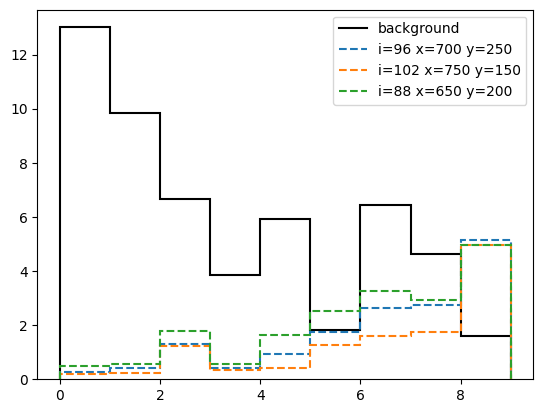

In [35]:
hep.histplot(b_9bins, label="background", color="black")
for i in np.random.permutation(len(signals_9bins))[:3]:
    signal = signals_9bins[i]
    hep.histplot(signal["data"], label=f"i={i} x={signal['x']} y={signal['y']}", linestyle="--")
plt.legend()

So by running the previous cell a few times you can see the distribution of the different signals is quite different, which makes a multi-bin search very powerful!

A little background information: Originally those 9 bins originated from 3 different, statistically independent signal regions. The first 3 bins are optimized for signals with low masses, the next 3 bins for signals with medium masses and the last 3 bins for signals with high masses. Here we don't care about the x-axis though, since we just want to do a statistical analysis.

So let's start with a 1D scan of all points with a neutralino mass (`y`) of 150 GeV:

In [36]:
# filter out all signals with y=150 and sort by x
signals_150 = sorted([i for i in signals_9bins if i["y"] == 150], key=lambda k: k["x"])

We will run an upper limit scan on the signal strength for each of these signal points (so in some sense we are actually doing already a 2D scan)

We will again use the `pyhf.simplemodels.uncorrelated_background` function and completely neglect any uncertainties:

In [37]:
limits = []
for signal in signals_150:
    model_s = pyhf.simplemodels.uncorrelated_background(
      signal=list(signal["data"]), bkg=list(b_9bins), bkg_uncertainty=[0] * 9
    )
    limit_obs, limit_exp = pyhf.infer.intervals.upper_limits.upper_limit(
        list(b_9bins) + model_s.config.auxdata,
        model_s,
    )
    # for now, we are just looking at the expected limit, since we didn't input any real data 
    limits.append(limit_exp)
limits = np.array(limits)

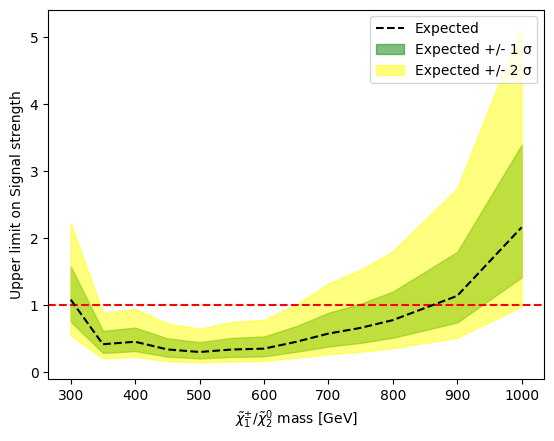

In [38]:
ax = plot_scan([i["x"] for i in signals_150], limits, exclusion_level=1)
ax.set_xlabel(r"$\tilde{\chi}_1^{\pm}/\tilde{\chi}_2^{0}$ mass [GeV]")
ax.set_ylabel("Upper limit on Signal strength")
ax.legend()

So the point at 300 GeV is at the boundary of exclusion and then the expected exclusion reaches up to around 850 GeV for these signals.

## Let's go 2D

As you have seen this example has 2 parameters, so we can run a 2D scan against both parameters. For this we don't do an upper limit scan for each point, but just calculate $CL_s$ for $\mu=1$ and look at the contour of $CL_s=0.05$ in the grid of the 2 parameters.

In [39]:
x = []
y = []
cls = []
for signal in signals_9bins:
    model_s = pyhf.simplemodels.uncorrelated_background(
      signal=list(signal["data"]), bkg=list(b_9bins), bkg_uncertainty=[0] * 9
    )
    cls_obs, cls_exp = pyhf.infer.hypotest(
        1,
        list(b_9bins) + model_s.config.auxdata,
        model_s,
        test_stat="qtilde",
        return_expected_set=True
    )
    x.append(signal["x"])
    y.append(signal["y"])
    cls.append(cls_exp)
x = np.array(x)
y = np.array(y)
cls = np.array(cls)

For better interpolation, we convert the $CL_s$ values to significances since they change much more linearily and are therefore easier to interpolate between:

In [40]:
z = pvalue_to_significance(cls)

Text(0.5, 1.0, 'Sorted Significance values')

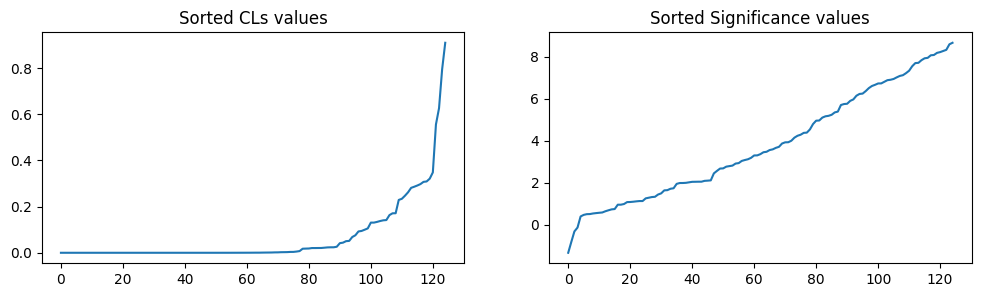

In [41]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 3))
ax[0].plot(sorted(cls[:, 2]))
ax[0].set_title("Sorted CLs values")
ax[1].plot(sorted(z[:, 2]))
ax[1].set_title("Sorted Significance values")

The significance level corresponding to a p-value of `0.05` is

In [42]:
level = pvalue_to_significance(0.05)
level

1.6448536269514729

You'll have the number `1.64` in your head after some time working for new physics searches :)

So, let's draw the contour in the 2D grid of our signal mass parameters. For such grids we don't overdo it and leave out the 2 sigma band. We use the `tricontour` functions of `matplotlib` to do a triangulation of our points in 3D (`x`, `y`, `z`) space and draw contours along that interpolated hill.

Reminder: the columns of expected $CL_s$ values are for `[-2, -1, 0, 1, 2]` sigma.

Text(0, 0.5, '$\\tilde{\\chi}_1^{0}$ mass [GeV]')

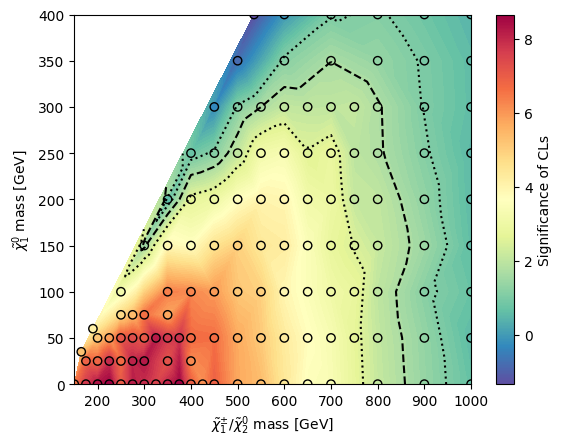

In [43]:
opt = dict(levels=[level], colors=["black"])
plt.tricontour(x, y, z[:, 2], linestyles="dashed", **opt)
plt.tricontour(x, y, z[:, 1], linestyles="dotted", **opt)
plt.tricontour(x, y, z[:, 3], linestyles="dotted", **opt)
plt.tricontourf(x, y, z[:, 2], levels=100, cmap="Spectral_r")
plt.scatter(x, y, c=z[:, 2], marker='o', edgecolor="black", cmap="Spectral_r")
plt.colorbar(label="Significance of CLs")
plt.xlabel(r"$\tilde{\chi}_1^{\pm}/\tilde{\chi}_2^{0}$ mass [GeV]")
plt.ylabel(r"$\tilde{\chi}_1^{0}$ mass [GeV]")

<div class="alert alert-block alert-success">
    <b>Question 7:</b> Which values of the signal parameters are expected to be excluded?
</div>

In [44]:
# Identify excluded points where significance is greater than the exclusion threshold
excluded_points = (z[:, 2] > 1.64)

# Print excluded (x, y) points
print("Excluded points (x, y):")
print(np.column_stack((x[excluded_points], y[excluded_points])))

Excluded points (x, y):
[[150   0]
 [165  35]
 [175   0]
 [175  25]
 [190  60]
 [200   0]
 [200  25]
 [200  50]
 [225   0]
 [225  25]
 [225  50]
 [250   0]
 [250 100]
 [250  25]
 [250  50]
 [250  75]
 [275   0]
 [275  25]
 [275  50]
 [275  75]
 [300   0]
 [300  25]
 [300  50]
 [300  75]
 [325   0]
 [325  50]
 [350   0]
 [350 100]
 [350 150]
 [350  25]
 [350  50]
 [350  75]
 [375   0]
 [375  50]
 [400   0]
 [400 100]
 [400 150]
 [400 200]
 [400  25]
 [400  50]
 [425   0]
 [450   0]
 [450 100]
 [450 150]
 [450 200]
 [450  50]
 [500   0]
 [500 100]
 [500 150]
 [500 200]
 [500 250]
 [500  50]
 [550   0]
 [550 100]
 [550 150]
 [550 200]
 [550 250]
 [550 300]
 [550  50]
 [600   0]
 [600 100]
 [600 150]
 [600 200]
 [600 250]
 [600 300]
 [600  50]
 [650   0]
 [650 100]
 [650 150]
 [650 200]
 [650 250]
 [650 300]
 [650  50]
 [700   0]
 [700 100]
 [700 150]
 [700 200]
 [700 250]
 [700 300]
 [700  50]
 [750 100]
 [750 150]
 [750 200]
 [750 250]
 [750 300]
 [750  50]
 [800   0]
 [800 100]
 [800 15

<div class="alert alert-block alert-success">
    <b>Bonus question 2:</b> How far would the expected limit go if we had twice the luminosity? 
</div>